In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
drive = False

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
if drive == False:
    sourcepath = '../Datos/Raw'
    destpath = '../Datos/Transformed'
else:     
    sourcepath = '/content/gdrive/My Drive/Colab Notebooks/TDG'
    destpath = sourcepath

items = pd.read_csv(f"{sourcepath}/ITEMS.csv")

In [5]:
items.head()

,SKU,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT
0,SKU1,IG71,NaN,HTS143,1,1,A,PC,20160914,CAT14
1,SKU2,IG71,NaN,HTS143,1,1,B,PC,20160914,CAT14
2,SKU3,IG71,NaN,HTS143,1,1,B,EA,20160630,CAT14
3,SKU4,IG71,NaN,HTS143,1,1,B,EA,20160630,CAT14
4,SKU5,IG22,IPG542,HTS48,1,1,C,RL,20180919,CAT7


In [6]:
items.tail()

,SKU,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT
11516,SKU11517,IG58,NaN,HTS133,2,0,C,PC,20110624,CAT16
11517,SKU11518,IG58,NaN,HTS133,2,0,C,PC,20110624,CAT16
11518,SKU11519,IG58,NaN,HTS110,1,1,C,PC,20110624,CAT16
11519,SKU11520,IG43,IPG763,HTS99,1,0,C,BX,20180521,CAT10
11520,SKU11521,IG43,IPG872,HTS89,2,0,C,BX,20161116,CAT10


In [7]:
locations = pd.read_csv(f"{sourcepath}/LOCATIONS.csv")

In [8]:
locations.head()

,WHS,ZONE,TYPE,AISLE,COLUMN,SHELF,LOC
0,80,WH,NaN,NaN,NaN,0,ACTELMA
1,80,WH,NaN,NaN,NaN,0,CY BULK
2,80,WH,NaN,NaN,NaN,0,DAVE1
3,80,WH,NaN,NaN,NaN,0,DEBBIE
4,80,WH,NaN,NaN,NaN,0,DM01


In [9]:
df = pd.read_csv(f"{sourcepath}/LOCTRANSCX.csv")

In [10]:
df.head()

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,...,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
0,20180210,SKU3921,17Q3,-1.0,17.0,Q,3,LOC4,IG56,NaN,...,20161028,CAT17,-289.8802,38.0,-3,0.0,0.0,0.0,0.0,0.01
1,20180210,SKU3922,17Q2,1.0,17.0,Q,2,LOC4,IG56,NaN,...,20161028,CAT17,289.5527,4.0,25,0.0,0.0,0.0,0.0,0.00
2,20180210,SKU3923,17W2,4.0,17.0,W,2,LOC4,IG56,NaN,...,20161028,CAT17,1111.3121,8.0,50,0.0,0.0,0.0,0.0,0.00
3,20180210,SKU3924,17B2,-1.0,17.0,B,2,LOC4,IG56,NaN,...,20161028,CAT17,-266.8633,11.0,-9,0.0,0.0,0.0,0.0,0.00
4,20180210,SKU3926,15P7,-2.0,15.0,P,7,LOC4,IG56,NaN,...,20161028,CAT17,-517.0436,18.0,-11,0.0,0.0,0.0,0.0,0.00


In [11]:
df.tail()

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,...,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
17002,20201213,SKU8964,23C10,1.0,23.0,C,10,LOC5,IG5,IPG1604,...,20000930,CAT2,316.3834,0.0,100,45.0,162.0,2.375,6.00,0.0
17003,20201213,SKU8971,21I2,2.0,21.0,I,2,LOC4,IG5,IPG1604,...,20001001,CAT2,626.9100,0.0,100,45.0,162.0,2.375,6.00,0.0
17004,20201213,SKU8972,22F8,15.0,22.0,F,8,LOC4,IG5,IPG1604,...,20000930,CAT2,4959.6974,11.0,136,45.0,162.0,2.375,6.00,0.0
17005,20201213,SKU8972,24I4,-4.0,24.0,I,4,LOC4,IG5,IPG1604,...,20000930,CAT2,-1322.5860,4.0,-100,45.0,162.0,2.375,6.00,0.0
17006,20201213,SKU8979,20G1,-1.0,20.0,G,1,LOC4,IG5,IPG1880,...,20050603,CAT2,-255.2001,2.0,-50,39.0,162.0,2.250,4.75,0.0


In [12]:
df['ABC'].value_counts(normalize=True)

A    0.447874
C    0.343212
B    0.208914
Name: ABC, dtype: float64

In [13]:
df['ABC'].value_counts()

A    7617
C    5837
B    3553
Name: ABC, dtype: int64

In [14]:
df['CLASS'].value_counts()

1    15768
2     1239
Name: CLASS, dtype: int64

In [15]:
df['PLANNING'].value_counts(normalize=True)

1    0.830423
0    0.168695
4    0.000529
2    0.000235
9    0.000118
Name: PLANNING, dtype: float64

In [16]:
df['CAT'].value_counts(normalize=True)*100

CAT17    24.143000
CAT12    15.523020
CAT14    14.893867
CAT16    14.723349
CAT8     13.400365
CAT7      7.255836
CAT3      3.175163
CAT10     1.534662
CAT5      1.181866
CAT2      1.175986
CAT9      0.940789
CAT1      0.881990
CAT4      0.611513
CAT15     0.511554
CAT6      0.041160
CAT11     0.005880
Name: CAT, dtype: float64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17007 entries, 0 to 17006
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TDATE      17007 non-null  int64  
 1   SKU        17007 non-null  object 
 2   LOC        17007 non-null  object 
 3   QTY        17007 non-null  float64
 4   AISLE      16935 non-null  float64
 5   COLUMN     16935 non-null  object 
 6   SHELF      17007 non-null  int64  
 7   TYPE       16935 non-null  object 
 8   IG         17007 non-null  object 
 9   IPG        8381 non-null   object 
 10  HTS        16997 non-null  object 
 11  CLASS      17007 non-null  int64  
 12  PLANNING   17007 non-null  int64  
 13  ABC        17007 non-null  object 
 14  UOM        17007 non-null  object 
 15  CREATION   17007 non-null  int64  
 16  CAT        17007 non-null  object 
 17  COSTX      17007 non-null  float64
 18  QTYBEFORE  17007 non-null  float64
 19  QTYVAR     17007 non-null  int64  
 20  WEIGHT

In [18]:
contingency= pd.crosstab(df['CLASS'], df['PLANNING']) 

In [19]:
contingency

PLANNING,0,1,2,4,9
CLASS,,,,,
1,1630,14123,4,9,2
2,1239,0,0,0,0


In [20]:
contingency_pct= pd.crosstab(df['CLASS'], df['PLANNING'],normalize='index') 

In [21]:
contingency_pct

PLANNING,0,1,2,4,9
CLASS,,,,,
1,0.103374,0.895675,0.000254,0.000571,0.000127
2,1.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:xlabel='PLANNING', ylabel='CLASS'>

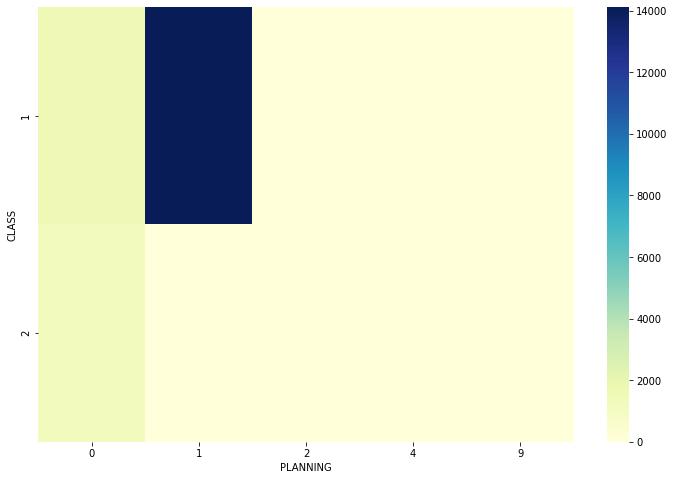

In [22]:
plt.figure(figsize=(12,8)) 
sns.heatmap(contingency, annot=False, cmap="YlGnBu")

In [23]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingency) 
# Print the p-value
print(p)
# Now, p < 0.05 is the usual test for dependence. In this case p is greater than 0.05, so we believe the variables are independent

0.0


In [24]:
# Dropping irrelevant columns
df = df.drop(['CREATION','IPG'], axis=1)

In [25]:
df = df.rename(columns={"WEIGHT":"PESO","LENGTH":"LARGO","HEIGHT":"ALTO","WIDTH":"ANCHO" })

In [26]:
df.head()

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,...,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC
0,20180210,SKU3921,17Q3,-1.0,17.0,Q,3,LOC4,IG56,HTS119,...,PC,CAT17,-289.8802,38.0,-3,0.0,0.0,0.0,0.0,0.01
1,20180210,SKU3922,17Q2,1.0,17.0,Q,2,LOC4,IG56,HTS119,...,PC,CAT17,289.5527,4.0,25,0.0,0.0,0.0,0.0,0.00
2,20180210,SKU3923,17W2,4.0,17.0,W,2,LOC4,IG56,HTS119,...,PC,CAT17,1111.3121,8.0,50,0.0,0.0,0.0,0.0,0.00
3,20180210,SKU3924,17B2,-1.0,17.0,B,2,LOC4,IG56,HTS119,...,PC,CAT17,-266.8633,11.0,-9,0.0,0.0,0.0,0.0,0.00
4,20180210,SKU3926,15P7,-2.0,15.0,P,7,LOC4,IG56,HTS119,...,PC,CAT17,-517.0436,18.0,-11,0.0,0.0,0.0,0.0,0.00


In [27]:
df.shape

(17007, 23)

In [28]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (674, 23)


In [29]:
duplicate_rows_df.head()

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,...,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC
10286,20201213,SKU10071,07G7,1.0,7.0,G,7,LOC4,IG8,HTS15,...,BX,CAT3,2094.1441,0.0,100,33.00,13.0,8.5,13.0,0.10
10288,20201213,SKU10071,10K2,1.0,10.0,K,2,LOC4,IG8,HTS15,...,BX,CAT3,2094.1441,0.0,100,33.00,13.0,8.5,13.0,0.10
10355,20201213,SKU10231,15U2,1500.0,15.0,U,2,LOC4,IG51,HTS15,...,PC,CAT16,1158.6669,0.0,100,0.01,0.5,0.5,0.5,0.05
10358,20201213,SKU10231,99D28,1500.0,99.0,D,28,LOC5,IG51,HTS15,...,PC,CAT16,1158.6669,0.0,100,0.01,0.5,0.5,0.5,0.05
10469,20201213,SKU10347,15G2,2.0,15.0,G,2,LOC4,IG57,HTS151,...,BX,CAT17,433.5837,0.0,100,2.00,4.0,3.0,16.0,0.03


In [30]:
df.loc[(df['TDATE']==20201213) & (df['SKU']=='SKU10071')]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,...,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC
10285,20201213,SKU10071,07G7,1.0,7.0,G,7,LOC4,IG8,HTS15,...,BX,CAT3,2094.1441,0.0,100,33.0,13.0,8.5,13.0,0.1
10286,20201213,SKU10071,07G7,1.0,7.0,G,7,LOC4,IG8,HTS15,...,BX,CAT3,2094.1441,0.0,100,33.0,13.0,8.5,13.0,0.1
10287,20201213,SKU10071,10K2,1.0,10.0,K,2,LOC4,IG8,HTS15,...,BX,CAT3,2094.1441,0.0,100,33.0,13.0,8.5,13.0,0.1
10288,20201213,SKU10071,10K2,1.0,10.0,K,2,LOC4,IG8,HTS15,...,BX,CAT3,2094.1441,0.0,100,33.0,13.0,8.5,13.0,0.1


In [31]:
# Dropping the duplicates 
df = df.drop_duplicates()

In [32]:
df.loc[(df['TDATE']==20201213) & (df['SKU']=='SKU10071')]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,...,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC
10285,20201213,SKU10071,07G7,1.0,7.0,G,7,LOC4,IG8,HTS15,...,BX,CAT3,2094.1441,0.0,100,33.0,13.0,8.5,13.0,0.1
10287,20201213,SKU10071,10K2,1.0,10.0,K,2,LOC4,IG8,HTS15,...,BX,CAT3,2094.1441,0.0,100,33.0,13.0,8.5,13.0,0.1


In [33]:
df.shape

(16333, 23)

In [34]:
# Finding the null values.
print(df.isnull().sum())

TDATE         0
SKU           0
LOC           0
QTY           0
AISLE        72
COLUMN       72
SHELF         0
TYPE         72
IG            0
HTS          10
CLASS         0
PLANNING      0
ABC           0
UOM           0
CAT           0
COSTX         0
QTYBEFORE     0
QTYVAR        0
PESO          0
LARGO         0
ALTO          0
ANCHO         0
CONTRPERC     0
dtype: int64


In [35]:
df[pd.isnull(df['TYPE'])]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,...,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC
94,20180210,SKU4109,99REC,-16.0,NaN,NaN,0,NaN,IG46,HTS121,...,PR,CAT17,-448.8740,16.0,-100,0.850,4.000,3.0,4.750,0.01
418,20180227,SKU4622,99REC,-2500.0,NaN,NaN,0,NaN,IG54,HTS119,...,PR,CAT16,-7873.8290,2500.0,-100,0.000,0.000,0.0,0.000,0.00
424,20180227,SKU4625,99REC,-525.0,NaN,NaN,0,NaN,IG54,HTS119,...,PR,CAT16,-3405.9674,525.0,-100,0.258,7.000,1.0,7.000,0.00
427,20180227,SKU4628,99REC,-6.0,NaN,NaN,0,NaN,IG53,HTS119,...,PR,CAT16,-71.2116,495.0,-1,0.000,0.000,0.0,0.000,0.01
462,20180228,SKU6013,99REC,-12.0,NaN,NaN,0,NaN,IG52,HTS119,...,PC,CAT16,-1325.9387,12.0,-100,4.350,67.000,2.5,2.500,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16387,20201213,SKU8625,1,-18.0,NaN,NaN,0,NaN,IG3,HTS97,...,BX,CAT1,-7803.8320,18.0,-100,47.000,18.125,2.5,18.125,0.01
16827,20190327,SKU1756,99REC,-1.0,NaN,NaN,0,NaN,IG64,HTS15,...,BX,CAT14,-1030.6617,1.0,-100,34.390,24.000,12.0,12.000,0.05
16841,20190716,SKU1755,99REC,5.0,NaN,NaN,0,NaN,IG64,HTS15,...,BX,CAT14,4828.6562,2.0,250,34.390,24.000,12.0,12.000,0.28
16842,20190716,SKU6149,99REC,-2.0,NaN,NaN,0,NaN,IG7,HTS95,...,BX,CAT8,-2187.8771,2.0,-100,60.000,192.000,3.0,7.000,0.03


In [36]:
df.loc[pd.isnull(df['TYPE']), 'TYPE'] = 'AREA' 

In [37]:
df.loc[pd.isnull(df['AISLE']), 'AISLE'] = df['LOC']

In [38]:
df.loc[pd.isnull(df['COLUMN']), 'COLUMN'] = ''

In [39]:
# Finding the null values.
print(df.isnull().sum())

TDATE         0
SKU           0
LOC           0
QTY           0
AISLE         0
COLUMN        0
SHELF         0
TYPE          0
IG            0
HTS          10
CLASS         0
PLANNING      0
ABC           0
UOM           0
CAT           0
COSTX         0
QTYBEFORE     0
QTYVAR        0
PESO          0
LARGO         0
ALTO          0
ANCHO         0
CONTRPERC     0
dtype: int64


In [40]:
df[df['TYPE']=='AREA']

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,...,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC
94,20180210,SKU4109,99REC,-16.0,99REC,,0,AREA,IG46,HTS121,...,PR,CAT17,-448.8740,16.0,-100,0.850,4.000,3.0,4.750,0.01
418,20180227,SKU4622,99REC,-2500.0,99REC,,0,AREA,IG54,HTS119,...,PR,CAT16,-7873.8290,2500.0,-100,0.000,0.000,0.0,0.000,0.00
424,20180227,SKU4625,99REC,-525.0,99REC,,0,AREA,IG54,HTS119,...,PR,CAT16,-3405.9674,525.0,-100,0.258,7.000,1.0,7.000,0.00
427,20180227,SKU4628,99REC,-6.0,99REC,,0,AREA,IG53,HTS119,...,PR,CAT16,-71.2116,495.0,-1,0.000,0.000,0.0,0.000,0.01
462,20180228,SKU6013,99REC,-12.0,99REC,,0,AREA,IG52,HTS119,...,PC,CAT16,-1325.9387,12.0,-100,4.350,67.000,2.5,2.500,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16387,20201213,SKU8625,1,-18.0,1,,0,AREA,IG3,HTS97,...,BX,CAT1,-7803.8320,18.0,-100,47.000,18.125,2.5,18.125,0.01
16827,20190327,SKU1756,99REC,-1.0,99REC,,0,AREA,IG64,HTS15,...,BX,CAT14,-1030.6617,1.0,-100,34.390,24.000,12.0,12.000,0.05
16841,20190716,SKU1755,99REC,5.0,99REC,,0,AREA,IG64,HTS15,...,BX,CAT14,4828.6562,2.0,250,34.390,24.000,12.0,12.000,0.28
16842,20190716,SKU6149,99REC,-2.0,99REC,,0,AREA,IG7,HTS95,...,BX,CAT8,-2187.8771,2.0,-100,60.000,192.000,3.0,7.000,0.03


In [41]:
df['HTS'].fillna("No HTS", inplace = True) 

In [42]:
df[df['HTS']=='No HTS']

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,...,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC
2447,20180723,SKU11504,15C2,-1.0,15,C,2,LOC4,IG58,No HTS,...,PC,CAT16,-627.4912,8.0,-13,1.4,8.00,2.50,4.00,0.0
9848,20200304,SKU11500,12W3,10.0,12,W,3,LOC4,IG58,No HTS,...,PC,CAT16,12317.7648,4.0,250,10.4,24.75,9.25,6.00,0.0
11274,20201213,SKU11157,37E7,-1.0,37,E,7,LOC4,IG19,No HTS,...,BG,CAT10,-0.0619,9.0,-11,1.0,4.50,1.00,9.00,0.0
11320,20201213,SKU11491,01C6,-24.0,1,C,6,LOC4,IG58,No HTS,...,PC,CAT16,-12806.2844,24.0,-100,2.0,37.50,3.25,6.00,0.0
11321,20201213,SKU11491,15O7,25.0,15,O,7,LOC4,IG58,No HTS,...,PC,CAT16,13339.8796,0.0,100,2.0,37.50,3.25,6.00,0.0
11322,20201213,SKU11493,17A6,1.0,17,A,6,LOC4,IG58,No HTS,...,PC,CAT16,624.7089,4.0,25,1.4,8.00,2.50,3.75,0.0
11323,20201213,SKU11500,12W3,1.0,12,W,3,LOC4,IG58,No HTS,...,PC,CAT16,1231.7765,14.0,7,10.4,24.75,9.25,6.00,0.0
11324,20201213,SKU11504,16G5,2.0,16,G,5,LOC4,IG58,No HTS,...,PC,CAT16,1254.9824,4.0,50,1.4,8.00,2.50,4.00,0.0
11325,20201213,SKU11509,16J1,6.0,16,J,1,LOC4,IG58,No HTS,...,PC,CAT16,10219.3022,0.0,100,11.4,28.50,6.00,9.00,0.0
11326,20201213,SKU11509,16J2,-6.0,16,J,2,LOC4,IG58,No HTS,...,PC,CAT16,-10219.3022,6.0,-100,11.4,28.50,6.00,9.00,0.0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16333 entries, 0 to 17006
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TDATE      16333 non-null  int64  
 1   SKU        16333 non-null  object 
 2   LOC        16333 non-null  object 
 3   QTY        16333 non-null  float64
 4   AISLE      16333 non-null  object 
 5   COLUMN     16333 non-null  object 
 6   SHELF      16333 non-null  int64  
 7   TYPE       16333 non-null  object 
 8   IG         16333 non-null  object 
 9   HTS        16333 non-null  object 
 10  CLASS      16333 non-null  int64  
 11  PLANNING   16333 non-null  int64  
 12  ABC        16333 non-null  object 
 13  UOM        16333 non-null  object 
 14  CAT        16333 non-null  object 
 15  COSTX      16333 non-null  float64
 16  QTYBEFORE  16333 non-null  float64
 17  QTYVAR     16333 non-null  int64  
 18  PESO       16333 non-null  float64
 19  LARGO      16333 non-null  float64
 20  ALTO  

<AxesSubplot:xlabel='QTY'>

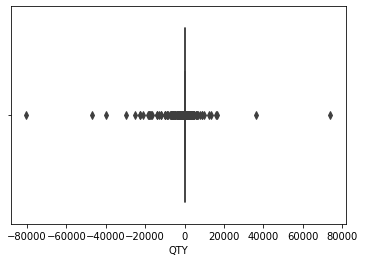

In [44]:
sns.boxplot(x=df['QTY'])

In [45]:
z = np.abs(stats.zscore(df.QTY))
#z = stats.zscore(df.QTY)
df['Zqty']=z
print(z)
# Z score = número de desviaciones estándar respecto a la media

[0.01747552 0.01904899 0.02140919 ... 0.03006328 0.01511531 0.01747552]


In [46]:
df.sample(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,...,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty
14872,20201213,SKU6351,12G5,35.0,12,G,5,LOC4,IG52,HTS119,...,CAT16,916.6234,328.0,11,0.068,4.50,0.25,2.00,0.00,0.045798
9539,20200203,SKU2751,10J3,-1.0,10,J,3,LOC4,IG14,HTS15,...,CAT8,-180.5413,18.0,-6,2.520,8.00,8.50,8.00,0.01,0.017476
3978,20181022,SKU9065,07Q7,-2.0,7,Q,7,LOC4,IG13,HTS119,...,CAT3,-903.7276,6.0,-33,35.280,25.75,8.50,12.75,0.02,0.016689
15717,20201213,SKU7850,15Y2,2.0,15,Y,2,LOC4,IG45,HTS24,...,CAT17,33.1065,0.0,100,0.520,3.75,3.75,6.00,0.03,0.019836
13529,20201213,SKU4206,12H5,-17.0,12,H,5,LOC4,IG46,HTS121,...,CAT17,-916.1063,17.0,-100,1.840,13.25,4.50,4.75,0.00,0.004888


In [47]:
df['QTY'].describe()

count    16333.000000
mean       -23.212714
std       1271.115065
min     -80500.000000
25%         -6.000000
50%         -1.000000
75%          4.000000
max      74000.000000
Name: QTY, dtype: float64

In [48]:
df['Zqty'].describe()

count    16333.000000
mean         0.100924
std          0.994925
min          0.000167
25%          0.016689
50%          0.019049
75%          0.026916
max         63.313899
Name: Zqty, dtype: float64

In [49]:
print('Dentro de 1 desviación estándar:', df.loc[df['Zqty'] < 1,'Zqty'].count(), round(df.loc[df['Zqty'] < 1,'Zqty'].count()/len(df)*100,2),'%')
print('Entre 1 y 2 desviaciones estándar:', df.loc[(df['Zqty'] >= 1) & (df['Zqty'] < 2),'Zqty'].count())
print('Entre 2 y 3 desviaciones estándar:', df.loc[(df['Zqty'] >= 2) & (df['Zqty'] < 3),'Zqty'].count())
print('Más de de 3 desviación estándar:', df.loc[df['Zqty'] > 3,'Zqty'].count())
print(df.loc[df['Zqty'] < 1,'Zqty'].count() + df.loc[(df['Zqty'] >= 1) & (df['Zqty'] < 2),'Zqty'].count() + df.loc[(df['Zqty'] >= 2) & (df['Zqty'] < 3),'Zqty'].count() + df.loc[df['Zqty'] > 3,'Zqty'].count())

Dentro de 1 desviación estándar: 16126 98.73 %
Entre 1 y 2 desviaciones estándar: 112
Entre 2 y 3 desviaciones estándar: 27
Más de de 3 desviación estándar: 68
16333


<AxesSubplot:xlabel='QTYVAR'>

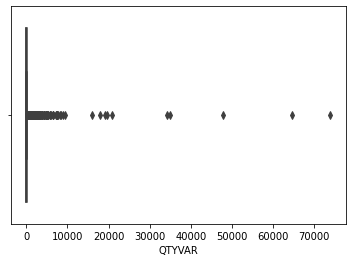

In [50]:
sns.boxplot(x=df['QTYVAR'])

In [51]:
df[df['QTYVAR']>10000]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,...,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty
1388,20180423,SKU7186,14O7,159.0,14,O,7,LOC4,IG45,HTS16,...,CAT17,4.912834e+03,1.0,15900,0.800,6.5,4.0,7.0,0.00,0.143353
2449,20180723,SKU1916,16O4,208.0,16,O,4,LOC4,IG49,HTS119,...,CAT16,4.778136e+03,1.0,20800,1.130,30.0,1.5,1.5,0.00,0.181903
3271,20180919,SKU6513,02K1,1719.0,2,K,1,LOC4,IG38,HTS61,...,CAT8,3.372806e+03,9.0,19100,0.060,148.0,3.0,11.0,0.16,1.370660
4142,20181029,SKU10933,20D2,647.0,20,D,2,LOC4,IG48,HTS24,...,CAT17,1.374824e+06,1.0,64700,5.000,192.0,1.0,2.0,0.00,0.527280
5215,20190116,SKU6481,02P1,3327.0,2,P,1,LOC4,IG38,HTS61,...,CAT8,8.974852e+03,17.0,19571,0.100,148.0,3.0,11.0,0.02,2.635729
5228,20190116,SKU6580,02P1,1746.0,2,P,1,LOC4,IG38,HTS61,...,CAT8,9.931164e+03,5.0,34920,0.070,148.0,3.0,7.0,0.19,1.391901
5232,20190116,SKU6621,02K3,1479.0,2,K,3,LOC4,IG38,HTS61,...,CAT8,4.704755e+03,2.0,73950,0.020,148.0,3.0,7.0,0.01,1.181843
5562,20190129,SKU4707,04D1,343.0,4,D,1,LOC4,IG30,HTS46,...,CAT12,8.827518e+03,1.0,34300,2.336,112.0,8.5,8.5,0.16,0.288112
9155,20191223,SKU7427,41E13,179.0,41,E,13,LOC5,IG26,HTS56,...,CAT7,2.468232e+04,1.0,17900,4.000,13.0,3.0,12.0,0.32,0.159088
10583,20201213,SKU10605,23F1,479.0,23,F,1,LOC4,IG55,HTS95,...,CAT16,1.151114e+03,1.0,47900,70.000,194.0,4.0,4.0,0.00,0.395108


In [52]:
z = np.abs(stats.zscore(df.QTYVAR))
#z = stats.zscore(df.QTYVAR)
df['ZqtyVar']=z
print(z)
# Z score = número de desviaciones estándar respecto a la media

[0.05199722 0.02521971 0.00131123 ... 0.08093397 0.14476215 0.09694517]


In [53]:
df.sample(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,...,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar
8388,20190916,SKU11394,39A1,-4.0,39,A,1,LOC4,IG25,HTS48,...,-413.3719,15.0,-27,1.000,10.5,2.0,3.0,0.01,0.015115,0.074949
7841,20190708,SKU2905,32B2,-26.0,32,B,2,LOC4,IG61,HTS6,...,-21674.2148,55.0,-47,79.700,192.0,6.0,6.0,4.63,0.002193,0.094076
5693,20190201,SKU2890,31E3,-29.0,31,E,3,LOC4,IG61,HTS6,...,-19107.1277,58.0,-50,63.000,192.0,6.0,6.0,0.01,0.004553,0.096945
10038,20200921,SKU5975,11E3,-2.0,11,E,3,LOC4,IG14,HTS15,...,-323.7151,2.0,-100,2.450,8.0,8.0,8.0,0.08,0.016689,0.144762
14019,20201213,SKU4690,03G4,-163.0,3,G,4,LOC4,IG30,HTS39,...,-4268.2264,163.0,-100,1.225,100.0,10.0,10.0,0.00,0.109976,0.144762


In [54]:
df['QTYVAR'].describe()

count    16333.000000
mean        51.371089
std       1045.685816
min       -100.000000
25%        -50.000000
50%         -1.000000
75%         48.000000
max      73950.000000
Name: QTYVAR, dtype: float64

In [55]:
df['ZqtyVar'].describe()

count    16333.000000
mean         0.122591
std          0.992488
min          0.000355
25%          0.046506
50%          0.052954
75%          0.142140
max         70.672175
Name: ZqtyVar, dtype: float64

In [56]:
print('Dentro de 1 desviación estándar:', df.loc[df['ZqtyVar'] < 1,'ZqtyVar'].count(), round(df.loc[df['ZqtyVar'] < 1,'ZqtyVar'].count()/len(df)*100,2),'%')
print('Entre 1 y 2 desviaciones estándar:', df.loc[(df['ZqtyVar'] >= 1) & (df['ZqtyVar'] < 2),'ZqtyVar'].count())
print('Entre 2 y 3 desviaciones estándar:', df.loc[(df['ZqtyVar'] >= 2) & (df['ZqtyVar'] < 3),'ZqtyVar'].count())
print('Más de de 3 desviación estándar:', df.loc[df['ZqtyVar'] > 3,'ZqtyVar'].count())
print(df.loc[df['ZqtyVar'] < 1,'ZqtyVar'].count() + df.loc[(df['ZqtyVar'] >= 1) & (df['ZqtyVar'] < 2),'ZqtyVar'].count() + df.loc[(df['ZqtyVar'] >= 2) & (df['ZqtyVar'] < 3),'ZqtyVar'].count() + df.loc[df['ZqtyVar'] > 3,'ZqtyVar'].count())

Dentro de 1 desviación estándar: 16199 99.18 %
Entre 1 y 2 desviaciones estándar: 57
Entre 2 y 3 desviaciones estándar: 26
Más de de 3 desviación estándar: 51
16333


In [57]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

TDATE        20189.000000
QTY             10.000000
SHELF            3.000000
CLASS            0.000000
PLANNING         0.000000
COSTX         1354.157400
QTYBEFORE      112.000000
QTYVAR          98.000000
PESO             9.540000
LARGO           96.000000
ALTO             5.750000
ANCHO            5.500000
CONTRPERC        0.030000
Zqty             0.010228
ZqtyVar          0.095634
dtype: float64


In [58]:
df[(df['SKU']=='SKU7427') & (df['TDATE']==20191223)]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,...,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar
9140,20191223,SKU7427,01H5,35.0,1,H,5,LOC4,IG26,HTS56,...,4826.1520,2.0,1750,4.0,13.0,3.0,12.0,0.32,0.045798,1.624466
9141,20191223,SKU7427,07T6,48.0,7,T,6,LOC4,IG26,HTS56,...,6618.7227,5.0,960,4.0,13.0,3.0,12.0,0.32,0.056026,0.868958
9142,20191223,SKU7427,07T7,-3.0,7,T,7,LOC4,IG26,HTS56,...,-413.6702,3.0,-100,4.0,13.0,3.0,12.0,0.32,0.015902,0.144762
9143,20191223,SKU7427,07Y7,-23.0,7,Y,7,LOC4,IG26,HTS56,...,-3171.4713,24.0,-96,4.0,13.0,3.0,12.0,0.32,0.000167,0.140937
9144,20191223,SKU7427,08O7,-10.0,8,O,7,LOC4,IG26,HTS56,...,-1378.9006,62.0,-16,4.0,13.0,3.0,12.0,0.32,0.010395,0.064430
9145,20191223,SKU7427,08T7,-30.0,8,T,7,LOC4,IG26,HTS56,...,-4136.7017,59.0,-51,4.0,13.0,3.0,12.0,0.32,0.005340,0.097902
9146,20191223,SKU7427,08Y6,9.0,8,Y,6,LOC4,IG26,HTS56,...,1241.0105,0.0,100,4.0,13.0,3.0,12.0,0.32,0.025343,0.046506
9147,20191223,SKU7427,38D13,86.0,38,D,13,LOC5,IG26,HTS56,...,11858.5448,14.0,614,4.0,13.0,3.0,12.0,0.32,0.085921,0.538064
9148,20191223,SKU7427,39D11,-90.0,39,D,11,LOC5,IG26,HTS56,...,-12410.1050,90.0,-100,4.0,13.0,3.0,12.0,0.32,0.052544,0.144762
9149,20191223,SKU7427,39G13,-100.0,39,G,13,LOC5,IG26,HTS56,...,-13789.0056,100.0,-100,4.0,13.0,3.0,12.0,0.32,0.060411,0.144762


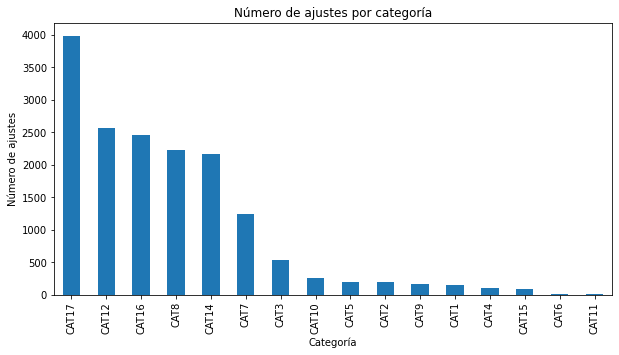

In [59]:
# Plotting a Histogram
df.CAT.value_counts().plot(kind='bar', figsize=(10,5))
# nlargest(40).
plt.title('Número de ajustes por categoría')
plt.ylabel('Número de ajustes')
plt.xlabel('Categoría');

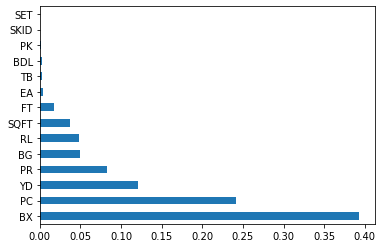

In [60]:
df.UOM.value_counts(normalize=True).plot.barh()
plt.show()

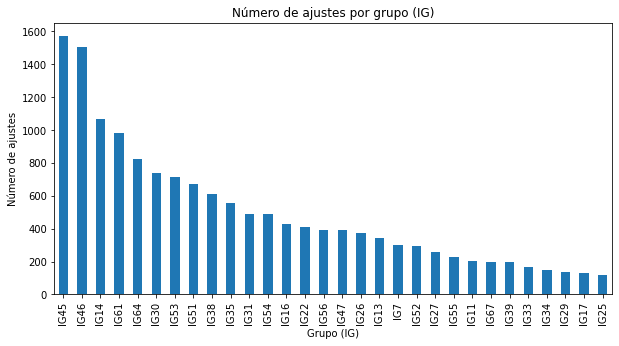

In [61]:
# Plotting a Histogram
df.IG.value_counts().nlargest(30).plot(kind='bar', figsize=(10,5))
plt.title('Número de ajustes por grupo (IG)')
plt.ylabel('Número de ajustes')
plt.xlabel('Grupo (IG)');

HTS119    23.12
HTS15     17.98
HTS24      9.35
HTS6       7.53
HTS61      4.62
HTS95      4.29
HTS48      3.22
HTS51      3.13
HTS55      2.66
HTS56      2.57
HTS121     2.46
HTS50      1.57
HTS16      1.46
HTS36      1.20
HTS46      0.99
Name: HTS, dtype: float64 %


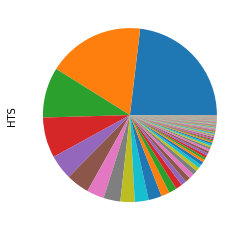

In [62]:
print(round(df.HTS.value_counts(normalize=True).nlargest(15)*100,2),'%')
df.HTS.value_counts(normalize=True).plot.pie(labels=None)
plt.show()

,TDATE,QTY,SHELF,CLASS,PLANNING,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar
TDATE,1.000000,0.017807,-0.091693,-0.079713,0.088400,0.015682,-0.025946,-0.001412,0.120337,0.156349,0.064915,0.086885,-0.013398,-0.006619,-0.019534
QTY,0.017807,1.000000,-0.012785,0.004871,0.000136,0.109472,-0.287369,0.030806,0.005541,0.012558,0.015803,0.018708,0.002922,-0.335535,0.021282
SHELF,-0.091693,-0.012785,1.000000,0.068924,-0.067587,-0.025366,-0.002054,-0.012306,-0.029280,-0.006146,-0.009147,-0.047383,0.006368,-0.003302,-0.002959
CLASS,-0.079713,0.004871,0.068924,1.000000,-0.596359,-0.003123,-0.032906,-0.011887,-0.011424,-0.103600,-0.097689,-0.073103,-0.058905,-0.022949,-0.006088
PLANNING,0.088400,0.000136,-0.067587,-0.596359,1.000000,-0.009597,0.032147,0.004980,0.003878,0.070446,0.064727,0.048574,0.087558,0.011159,0.000364
COSTX,0.015682,0.109472,-0.025366,-0.003123,-0.009597,1.000000,-0.014886,0.433033,-0.004835,0.008786,-0.007550,-0.006620,-0.022204,-0.000228,0.414685
QTYBEFORE,-0.025946,-0.287369,-0.002054,-0.032906,0.032147,-0.014886,1.000000,-0.006658,-0.033703,-0.053230,-0.077967,-0.082413,-0.016445,0.400118,-0.007595
QTYVAR,-0.001412,0.030806,-0.012306,-0.011887,0.004980,0.433033,-0.006658,1.000000,-0.002857,0.028041,-0.003830,0.003290,0.006088,0.019121,0.994428
PESO,0.120337,0.005541,-0.029280,-0.011424,0.003878,-0.004835,-0.033703,-0.002857,1.000000,0.298196,0.211847,0.174503,0.184357,-0.022004,-0.004037
LARGO,0.156349,0.012558,-0.006146,-0.103600,0.070446,0.008786,-0.053230,0.028041,0.298196,1.000000,0.104923,0.183552,0.208170,-0.024292,0.031861


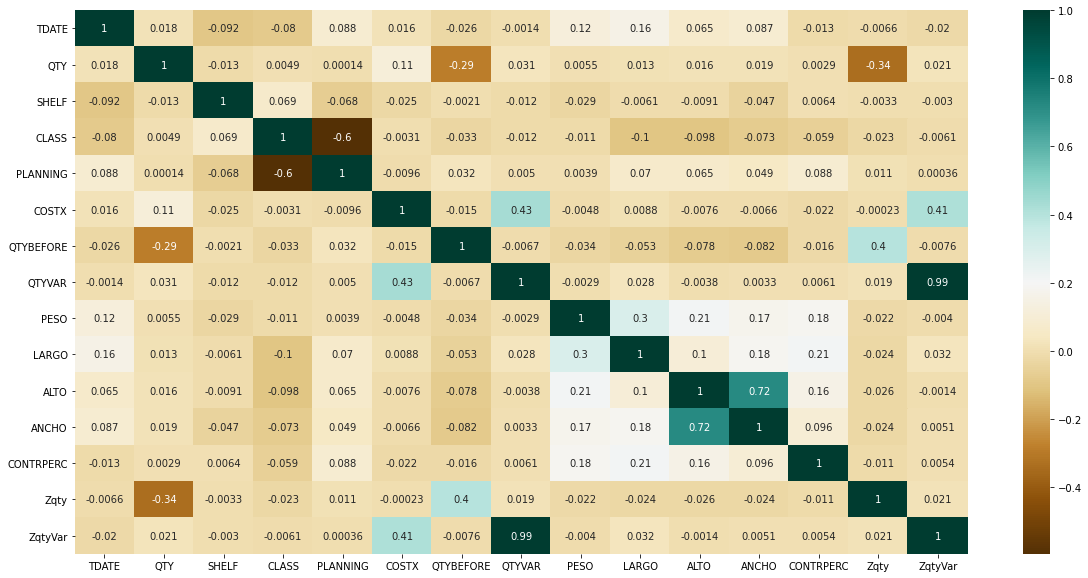

In [63]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
c= df.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
c

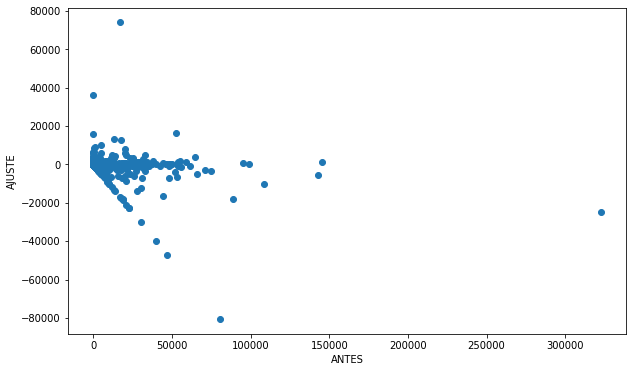

In [64]:
# Plotting a scatter plot
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df['QTYBEFORE'], df['QTY'])
ax.set_xlabel('ANTES')
ax.set_ylabel('AJUSTE')
plt.show()

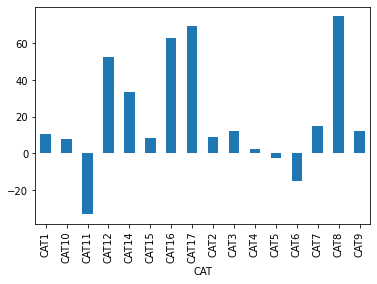

In [65]:
df.groupby('CAT')['QTYVAR'].mean().plot.bar()
#print(result)
plt.show()

In [66]:
df.describe()

,TDATE,QTY,SHELF,CLASS,PLANNING,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar
count,1.633300e+04,16333.000000,16333.000000,16333.000000,16333.000000,1.633300e+04,16333.000000,16333.000000,16333.000000,16333.000000,16333.000000,16333.000000,16333.000000,16333.000000,16333.000000
mean,2.019207e+07,-23.212714,3.814547,1.075246,0.829425,-6.718157e+01,544.853870,51.371089,13.663001,54.039599,4.842184,5.714558,0.089230,0.100924,0.122591
std,8.791539e+03,1271.115065,2.835252,0.263797,0.396746,1.332430e+04,4519.798788,1045.685816,43.087181,64.998684,4.700551,4.384212,0.420496,0.994925,0.992488
min,2.018021e+07,-80500.000000,0.000000,1.000000,0.000000,-2.298156e+05,-44.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000167,0.000355
25%,2.018102e+07,-6.000000,2.000000,1.000000,1.000000,-7.360974e+02,2.000000,-50.000000,0.460000,6.000000,1.500000,2.500000,0.000000,0.016689,0.046506
50%,2.019073e+07,-1.000000,3.000000,1.000000,1.000000,-3.356930e+01,18.000000,-1.000000,2.037000,12.000000,3.500000,5.500000,0.010000,0.019049,0.052954
75%,2.020121e+07,4.000000,5.000000,1.000000,1.000000,6.180600e+02,114.000000,48.000000,10.000000,102.000000,7.250000,8.000000,0.030000,0.026916,0.142140
max,2.021021e+07,74000.000000,36.000000,2.000000,9.000000,1.374824e+06,322475.000000,73950.000000,3250.000000,241.000000,50.500000,48.000000,4.630000,63.313899,70.672175


In [67]:
df.sample(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,...,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar
13320,20201213,SKU4086,14G8,-15.0,14,G,8,LOC4,IG46,HTS119,...,-539.1549,518.0,-3,0.87,10.0,3.50,6.0,0.00,0.006461,0.051997
9011,20191126,SKU4715,04W2,6.0,4,W,2,LOC4,IG31,HTS55,...,638.0784,227.0,3,1.84,112.0,8.50,8.5,0.02,0.022983,0.046259
9253,20200103,SKU174,08C1,-3.0,8,C,1,LOC4,IG14,HTS9,...,-326.8565,38.0,-8,3.49,9.0,1.25,9.0,0.01,0.015902,0.056779
4894,20181204,SKU1634,37A2,-1.0,37,A,2,LOC4,IG64,HTS15,...,-1432.0346,1.0,-100,10.00,16.0,14.00,12.0,0.00,0.017476,0.144762
10109,20200924,SKU6646,02P4,-266.0,2,P,4,LOC4,IG38,HTS61,...,-715.8226,662.0,-40,0.03,148.0,3.00,7.0,0.00,0.191009,0.087382


In [68]:
df.query('LARGO > ALTO')

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,...,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar
28,20180210,SKU3992,12I6,-144.0,12,I,6,LOC4,IG46,HTS119,...,-8177.0401,144.0,-100,1.7,36.5,3.250,3.00,0.01,0.095028,0.144762
29,20180210,SKU3992,17E5,-4.0,17,E,5,LOC4,IG46,HTS119,...,-227.1400,102.0,-4,1.7,36.5,3.250,3.00,0.01,0.015115,0.052954
30,20180210,SKU3992,17V1,3.0,17,V,1,LOC4,IG46,HTS119,...,170.3550,158.0,2,1.7,36.5,3.250,3.00,0.01,0.020622,0.047216
31,20180210,SKU3993,13L6,-6.0,13,L,6,LOC4,IG46,HTS119,...,-340.7100,97.0,-6,1.7,36.5,3.250,3.00,0.04,0.013542,0.054866
32,20180210,SKU3993,13T1,-52.0,13,T,1,LOC4,IG46,HTS119,...,-2952.8200,53.0,-98,1.7,36.5,3.250,3.00,0.04,0.022648,0.142849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17002,20201213,SKU8964,23C10,1.0,23,C,10,LOC5,IG5,HTS67,...,316.3834,0.0,100,45.0,162.0,2.375,6.00,0.00,0.019049,0.046506
17003,20201213,SKU8971,21I2,2.0,21,I,2,LOC4,IG5,HTS67,...,626.9100,0.0,100,45.0,162.0,2.375,6.00,0.00,0.019836,0.046506
17004,20201213,SKU8972,22F8,15.0,22,F,8,LOC4,IG5,HTS67,...,4959.6974,11.0,136,45.0,162.0,2.375,6.00,0.00,0.030063,0.080934
17005,20201213,SKU8972,24I4,-4.0,24,I,4,LOC4,IG5,HTS67,...,-1322.5860,4.0,-100,45.0,162.0,2.375,6.00,0.00,0.015115,0.144762


In [69]:
#print(df.shape)
#df=df[df['ZqtyVar'] < 3]
#print(df.shape)
# Crear buckets?
# pairplot?
# Heatmap por grupos:
#result = pd.pivot_table(data=df, index='CATEGORICAL1', columns='CATEGORICAL2',values='NUMERICA')
#
#create heat map of education vs marital vs response_rate
#plt.show()
# Escalar
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(X)
# rescaledX = scaler.transform(X)